In [1]:
%load_ext autoreload
%autoreload 2

# Init

In [2]:
import json
import sys
import re
import pickle as pkl
from pathlib import Path
from pprint import pprint
from collections import defaultdict
sys.path.append("../src")

import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

import constants
from scoring import chart
from gen.util import read_data, write_jsonl

In [3]:
da_root = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/models/decomposable-attention")

da_acc_fever = da_root / "fever-da-doc-hp_tune"
da_acc_cfever = da_root / "climatefeverpure-da-doc-hp_tune"
da_acc_c_fever = da_root / "fever-climatefeverpure-da-doc-hp_tune"

# Hyperparameter tuning

In [4]:
def augment_metric(met):
    met["bias_variance"] = met["validation_loss"] - met["training_loss"]
    met["acc_diff"] = met["training_accuracy"] - met["validation_accuracy"]
    met["macro_fscore_diff"] = met["training_macro_fscore"] - met["validation_macro_fscore"]
    
    min_val_loss = fmet.nsmallest(5, columns="validation_loss", keep="first")[["epoch", "validation_loss", "bias_variance"]]
    min_val_loss["metric"] = "validation_loss"
    max_acc = fmet.nlargest(5, columns="validation_accuracy", keep="first")[["epoch", "validation_accuracy", "bias_variance"]]
    max_acc["metric"] = "validation_accuracy"
    max_f1 = fmet.nsmallest(5, columns="validation_macro_fscore", keep="first")[["epoch", "validation_macro_fscore", "bias_variance"]]
    max_f1["metric"] = "validation_macro_fscore"
    
    return pd.concat([min_val_loss, max_acc, max_f1], axis=0)

## FEVER

Using epoch 95

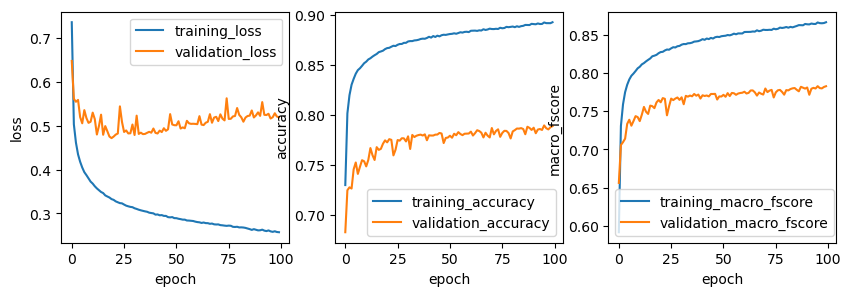

In [5]:
ax, fmet = chart.plot_finetune(da_acc_fever, return_metric=True)
fminmax = augment_metric(fmet)

In [6]:
fmet.loc[fmet["epoch"].isin(list(fminmax["epoch"].values)), ["epoch", "validation_loss", "validation_accuracy", "validation_macro_fscore"]]

,epoch,validation_loss,validation_accuracy,validation_macro_fscore
82,0,0.647045,0.682868,0.656066
40,1,0.560784,0.724772,0.705615
55,2,0.554132,0.727673,0.709373
14,3,0.558357,0.726473,0.713901
99,6,0.535189,0.741074,0.730893
42,15,0.479012,0.767777,0.757146
27,18,0.475038,0.771177,0.761358
39,19,0.471496,0.774577,0.764549
44,20,0.474956,0.772577,0.761541
21,30,0.478589,0.778578,0.768037


In [7]:
fmet.loc[fmet["epoch"] == fmet["best_epoch"].max(), ["epoch", "validation_loss", "validation_accuracy", "validation_macro_fscore"]]

,epoch,validation_loss,validation_accuracy,validation_macro_fscore
36,95,0.516032,0.789479,0.7826


## Climate-FEVER Pure

Using epoch 44

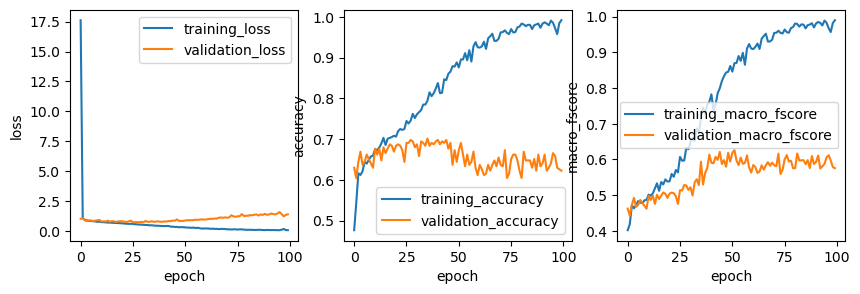

In [8]:
ax, fmet = chart.plot_finetune(da_acc_cfever, return_metric=True)
fminmax = augment_metric(fmet)

In [9]:
fmet.loc[fmet["epoch"].isin(list(fminmax["epoch"].values)), ["epoch", "validation_loss", "validation_accuracy", "validation_macro_fscore"]]

,epoch,validation_loss,validation_accuracy,validation_macro_fscore
82,0,1.008676,0.629496,0.462074
40,1,1.053158,0.604317,0.442348
94,4,0.877514,0.636691,0.467202
71,8,0.885948,0.640288,0.469927
12,9,0.904824,0.629496,0.461732
11,25,0.716907,0.690647,0.513763
66,26,0.728046,0.690647,0.512841
34,27,0.732793,0.697842,0.528154
37,28,0.718669,0.694245,0.526902
21,30,0.718422,0.687050,0.521760


In [10]:
fmet.loc[fmet["epoch"] == fmet["best_epoch"].max(), ["epoch", "validation_loss", "validation_accuracy", "validation_macro_fscore"]]

,epoch,validation_loss,validation_accuracy,validation_macro_fscore
60,51,0.889394,0.690647,0.625917


## FEVER + Climate-FEVER Pure

Using epoch 86

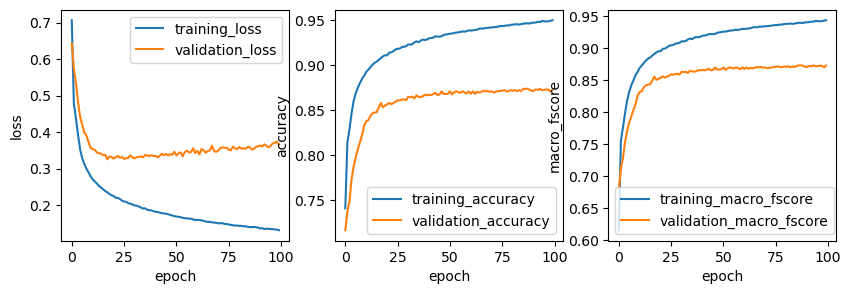

In [12]:
ax, fmet = chart.plot_finetune(da_acc_c_fever, return_metric=True)
fminmax = augment_metric(fmet)

In [13]:
fmet.loc[fmet["epoch"].isin(list(fminmax["epoch"].values)), ["epoch", "validation_loss", "validation_accuracy", "validation_macro_fscore"]]

,epoch,validation_loss,validation_accuracy,validation_macro_fscore
82,0,0.643734,0.716162,0.680706
40,1,0.573897,0.736694,0.711807
55,2,0.535532,0.748467,0.728413
14,3,0.482635,0.773086,0.753997
94,4,0.441761,0.787195,0.770903
43,17,0.325606,0.857935,0.855184
44,20,0.327700,0.856378,0.853502
11,25,0.326654,0.860952,0.858846
66,26,0.328411,0.860660,0.858314
21,30,0.328325,0.864649,0.862978


In [14]:
fmet.loc[fmet["epoch"] == fmet["best_epoch"].max(), ["epoch", "validation_loss", "validation_accuracy", "validation_macro_fscore"]]

,epoch,validation_loss,validation_accuracy,validation_macro_fscore
54,93,0.362995,0.873601,0.87308
